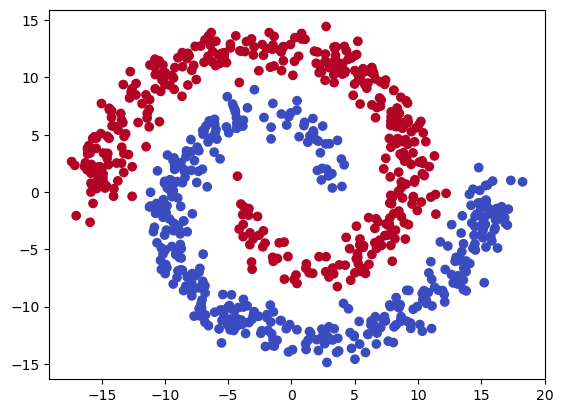

[[1 0]
 [1 0]
 [0 1]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [13]:
# Import variation of 2 spiral problem supplied in PDF
import numpy as np
from numpy import pi
import pandas as pd
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import time

torch.manual_seed(42)

N = 400
theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

np.savetxt("DataSets/variationspiralDataset.csv", res, delimiter=",", header="", comments="", fmt='%.5f')
data = pd.read_csv('datasets/variationspiralDataset.csv', header=None, names=['x1', 'x2', 'y'])
# Split the dataset into features and labels
X = data[['x1', 'x2']].to_numpy()
y = data['y'].to_numpy()
svm_y = y.flatten()

# # Plot the dataset
plt.scatter(X[:,0],X[:,1], c=y, cmap='coolwarm')
plt.show()
y = data['y'].to_numpy().astype(int)
new_arr = np.where(y == 0, 1,0)
y = np.column_stack((new_arr,y))
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

#Declare empty Net class so that the training process can be defined before the specifics of each neural network are made such as the number of hidden layers and activation functions used
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()




In [14]:
##Function For calculating average accuracy
def calculate_accuracy(fold_training_accs,fold_test_accs):

    avg_train_accs, avg_test_accs = 0,0
    print("Training Results")
    for i in range(len(fold_training_accs)):
        print(f"Fold {i+1} Training Accuracy: {fold_training_accs[i]}, Test Accuracy:{fold_test_accs[i]}")
        avg_train_accs = avg_train_accs  + fold_training_accs[i]
        avg_test_accs = avg_test_accs + fold_test_accs[i]
    avg_train_accs = avg_train_accs/len(fold_training_accs)
    avg_test_accs = avg_test_accs/len(fold_test_accs)
    print()
    print("Testing Results:")
    print(f"Overall Training Accuracy: {avg_train_accs}")
    print()
    print(f"Overall Test Accuracy: {avg_test_accs}")

    return 


def calculate_losses(train_losses,test_losses,num_folds):

    for i in range(num_folds):
        print('Fold {}, Training loss: {:.4f}, Test loss: {:.4f}'
        .format(i+1, train_losses[i], test_losses[i]))

    avg_train_loss = sum(train_losses) / num_folds
    avg_test_loss = sum(test_losses) / num_folds
    print()
    print('Average Training loss: {:.4f}, Average Test loss: {:.4f}'
    .format(avg_train_loss, avg_test_loss))
    print("\n\n")

In [15]:
#Define the training function that trains the FFNN based on the data and hyper parameters
def train_FFNN(X,y,num_folds,num_epochs,learning_rate,input_size,hidden_size,output_size):


    start_time = time.time()
    criterion = nn.BCELoss()
    #Breaks data up into K-folds that are then trained and tested on independently
    kf = KFold(n_splits=num_folds, shuffle= True, random_state= 42)
    # Arrays that store information on models performance
    loss_list = []
    train_losses = []
    test_losses = []
    fold_test_accs = []
    fold_training_accs = []
    grid_predicted_folds = []
    time_fold = []
    #loops through the training process with the split up data for K Folds
    for fold, (train, test) in enumerate(kf.split(X)):
        net = Net(input_size, hidden_size, output_size)
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
        fold_start_time = time.time()
        print(f"Fold {fold + 1}/{num_folds}")
        print(X)
        print(train)
        # Split the dataset into training and test data
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        # Convert the training and test data to PyTorch tensors
        X_train = torch.from_numpy(X_train).type(torch.float32)
        X_test = torch.from_numpy(X_test).type(torch.float32)
        y_train = torch.from_numpy(y_train).type(torch.float32)
        y_test = torch.from_numpy(y_test).type(torch.float32)


         # Train the FFNN
        for epoch in range(num_epochs):
            # Forward pass
            outputs = net(X_train)
            loss = criterion(outputs, y_train)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Save the loss for this epoch
            loss_list.append(loss.item())

        # Save the training and test losses for this fold
        train_losses.append(loss_list[-1])
        test_loss = criterion(net(X_test), y_test)
        test_losses.append(test_loss.item())
        
        with torch.no_grad():
            outputs = net(X_train)
            _, predicted_class = torch.max(outputs.data, 1)
            predicted_class = np.array(predicted_class)
            fold_correct = sum(predicted_class[i] == y_train[i].argmax() for i in range(len(predicted_class)))
            fold_training_accs.append(fold_correct/len(y_train))
        
        #evaluates the test set to determine the accuracy
        with torch.no_grad():
            outputs = net(X_test)
            _, predicted_class = torch.max(outputs.data, 1)
            predicted_class = np.array(predicted_class)
            fold_correct = sum(predicted_class[i] == y_test[i].argmax() for i in range(len(predicted_class)))
            fold_test_accs.append(fold_correct/len(y_test))
    
        x1_min, x1_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
        x2_min, x2_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
        xx, yy = torch.meshgrid(torch.linspace(x1_min, x1_max, 100),
                                torch.linspace(x2_min, x2_max, 100))
        X_grid = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)), dim=1)
        
        # Get the predicted_class class labels for the grid points
        with torch.no_grad():
            grid_outputs = net(X_grid)
            grid_predicted_class = torch.argmax(grid_outputs, dim=1)

        grid_predicted_folds.append(grid_predicted_class)
        # Plot the decision boundary
        plt.contourf(xx, yy, grid_predicted_class.reshape(xx.shape), cmap='coolwarm', alpha=0.5)
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.argmax(axis=1), cmap='coolwarm')
        plt.title('Decision Boundary')
        plt.show()
        end_fold_time = time.time()
        fold_time = -1*(fold_start_time - end_fold_time)
        print(f"Time elapsed: {fold_time:.2f} seconds")
        time_fold.append(fold_time)
        net = None  
        
    #Calculate the average training and validation loss across all folds
    avg_train_loss = sum(train_losses) / num_folds
    avg_test_loss = sum(test_losses) / num_folds
    print('Average train loss: {:.4f}, Average val loss: {:.4f}'
        .format(avg_train_loss, avg_test_loss))
    
    calculate_losses(train_losses,test_losses,num_folds)
    calculate_accuracy(fold_training_accs,fold_test_accs)

    #Determine the average decision boundary across all 10 folds
    grid_predicted_folds = torch.stack(grid_predicted_folds)
    grid_predictions, _ = torch.mode(grid_predicted_folds, dim=0)    
    plt.contourf(xx, yy, grid_predictions.reshape(xx.shape), cmap='coolwarm', alpha=0.5)
    # plt.scatter(X[:, 0], X[:, 1], c=y.argmax(axis=1), cmap='coolwarm')
    plt.title('Decision Boundary')
    plt.show()


    end_time = time.time()
    elapsed_time = end_time - start_time
    average_time = sum(time_fold)/num_folds
    print(f"Average Fold Time: {average_time:.2f} Time elapsed: {elapsed_time:.2f} seconds")


Fold 1/10
[[-10.2834   -1.55492]
 [ -8.71022  -4.9332 ]
 [  1.0699   13.33009]
 ...
 [ -4.40184  13.62807]
 [  8.48576  -1.65946]
 [ -2.30995  12.86967]]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  24  25  26  27  28  29  32  34  35  36  37  38  40
  41  42  43  44  45  46  47  48  50  51  52  53  54  55  56  57  58  59
  60  61  62  64  68  69  70  71  72  73  74  75  76  77  79  80  81  82
  83  84  85  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 169 170 171 172 173 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 193 194 195 196
 197 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 216 217
 218 219 220 221 222 223 224 225 226 227 22

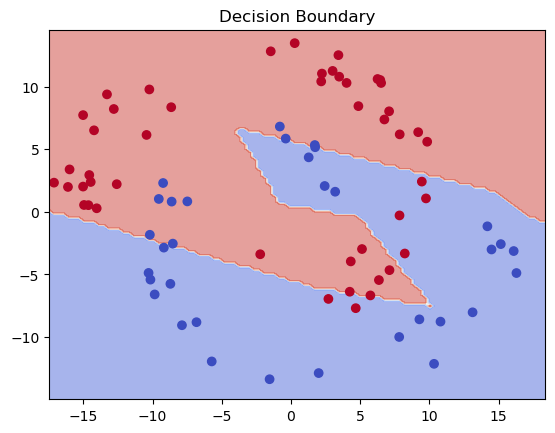

Time elapsed: 0.51 seconds
Fold 2/10
[[-10.2834   -1.55492]
 [ -8.71022  -4.9332 ]
 [  1.0699   13.33009]
 ...
 [ -4.40184  13.62807]
 [  8.48576  -1.65946]
 [ -2.30995  12.86967]]
[  0   1   3   4   5   6   8   9  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  73  74  75  78  79
  80  82  83  85  86  87  88  89  90  91  92  93  94  95  98  99 100 102
 103 104 105 106 107 108 109 111 112 113 114 115 116 117 119 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 205 206 207 212 213 214 215 216 217 219 220 221
 222 223 224 225

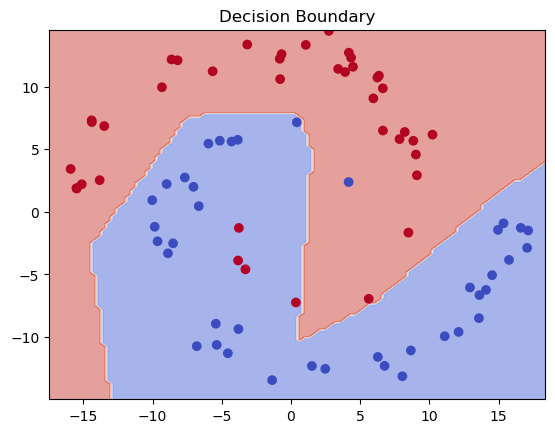

Time elapsed: 0.47 seconds
Fold 3/10
[[-10.2834   -1.55492]
 [ -8.71022  -4.9332 ]
 [  1.0699   13.33009]
 ...
 [ -4.40184  13.62807]
 [  8.48576  -1.65946]
 [ -2.30995  12.86967]]
[  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  45  46  47  48  49  50  51  52  53  54  56  57
  58  59  61  62  63  64  65  66  67  68  71  72  74  75  76  77  78  80
  81  83  84  85  86  87  88  89  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 134 137 138 139 141 142
 143 144 146 147 149 150 151 152 153 154 155 156 157 159 160 161 162 163
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 182 183 184
 185 186 187 188 189 190 191 192 194 195 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 214 215 216 217 218 219 221 222 223 224
 225 226 227 228

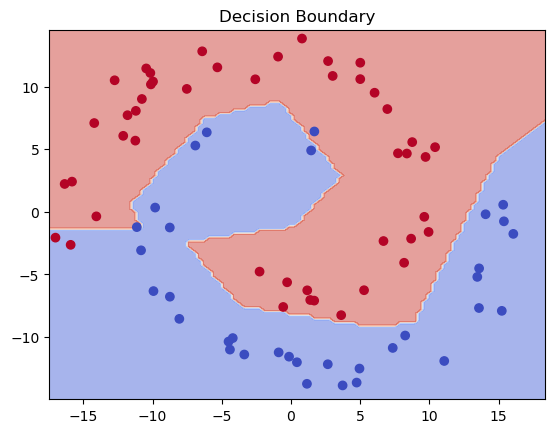

Time elapsed: 0.35 seconds
Fold 4/10
[[-10.2834   -1.55492]
 [ -8.71022  -4.9332 ]
 [  1.0699   13.33009]
 ...
 [ -4.40184  13.62807]
 [  8.48576  -1.65946]
 [ -2.30995  12.86967]]
[  0   1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  19
  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  44  45  46  47  48  49  50  52  53  54  55  57  58  59  60  62
  63  64  65  66  67  68  69  70  71  72  73  75  76  77  78  79  80  81
  82  84  85  86  87  88  90  91  93  94  95  96  97  98  99 100 101 102
 103 105 106 107 109 110 111 112 113 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 164 165 166 168 169 170 171 172 173 174 175 179 180 181 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 213 214 215 216 217 218 219 220
 221 222 224 225

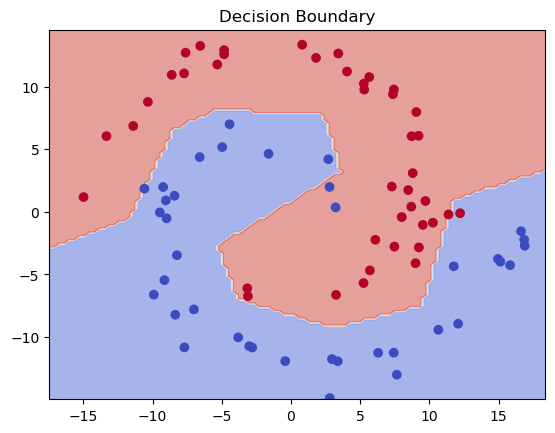

Time elapsed: 0.35 seconds
Fold 5/10
[[-10.2834   -1.55492]
 [ -8.71022  -4.9332 ]
 [  1.0699   13.33009]
 ...
 [ -4.40184  13.62807]
 [  8.48576  -1.65946]
 [ -2.30995  12.86967]]
[  1   2   4   5   6   7   8  10  11  12  13  14  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  69  70  71  72  73  74  76  77  78
  79  80  81  82  83  84  85  86  87  89  90  91  92  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 118
 119 120 121 122 123 124 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 145 146 147 148 149 150 151 152 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 185 186 187 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218

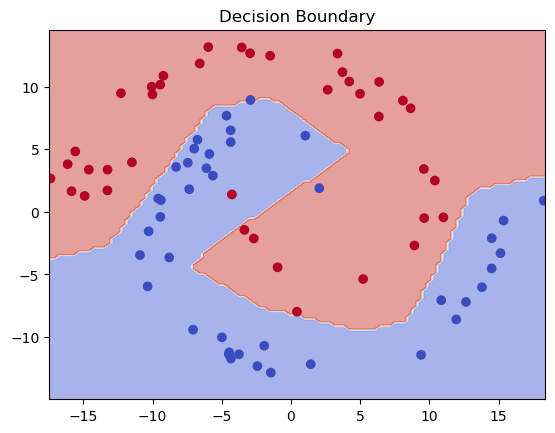

Time elapsed: 0.37 seconds
Fold 6/10
[[-10.2834   -1.55492]
 [ -8.71022  -4.9332 ]
 [  1.0699   13.33009]
 ...
 [ -4.40184  13.62807]
 [  8.48576  -1.65946]
 [ -2.30995  12.86967]]
[  0   1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18
  20  21  22  23  24  26  27  28  29  30  31  32  33  34  35  36  37  39
  40  41  42  43  44  45  47  48  49  51  52  53  54  55  56  58  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 101 102 103 104 105 106 108 109 110 111 112 114 115 116 117 118
 119 120 121 122 123 125 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 143 144 145 146 147 148 150 151 152 153 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 170 171 174 176 177 178 180 181 182 183
 184 186 187 188 189 190 191 192 193 194 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 223 224 225 226

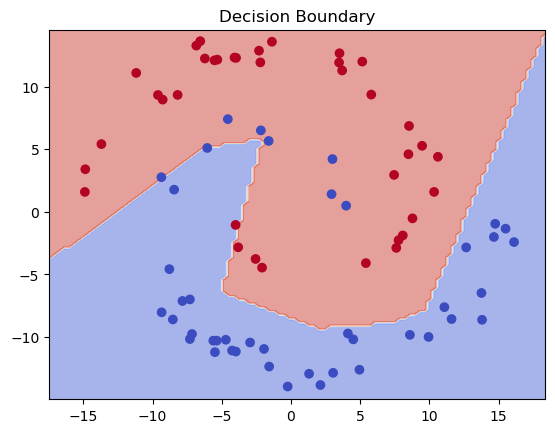

Time elapsed: 0.46 seconds
Fold 7/10
[[-10.2834   -1.55492]
 [ -8.71022  -4.9332 ]
 [  1.0699   13.33009]
 ...
 [ -4.40184  13.62807]
 [  8.48576  -1.65946]
 [ -2.30995  12.86967]]
[  0   1   2   3   4   6   7   9  10  11  12  13  14  15  18  19  20  21
  22  23  24  25  27  28  29  30  31  32  33  34  35  36  38  39  40  41
  42  43  44  46  47  49  50  51  52  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  95  96  97  98  99
 100 101 102 104 105 106 107 108 109 110 112 113 114 116 117 118 120 121
 122 123 124 125 126 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 153 154 155 156 158 159 160 161
 163 164 165 166 167 168 169 170 172 173 174 175 176 177 178 179 181 182
 183 184 185 186 187 188 189 191 192 193 195 196 197 198 199 200 201 202
 203 204 205 206 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 227

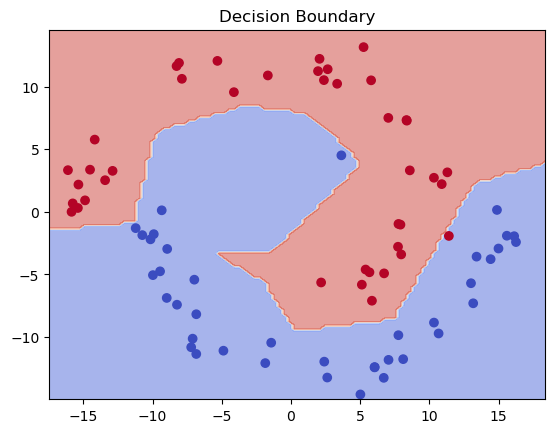

Time elapsed: 0.42 seconds
Fold 8/10
[[-10.2834   -1.55492]
 [ -8.71022  -4.9332 ]
 [  1.0699   13.33009]
 ...
 [ -4.40184  13.62807]
 [  8.48576  -1.65946]
 [ -2.30995  12.86967]]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 113 114 115 116 117 118 119 120 121 124 125 126 127 128 130
 131 132 133 134 135 136 137 138 139 140 141 142 144 145 148 149 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 184 185 187 188 189 190
 191 192 193 194 195 196 198 199 200 201 203 204 205 206 207 208 209 210
 211 212 213 214

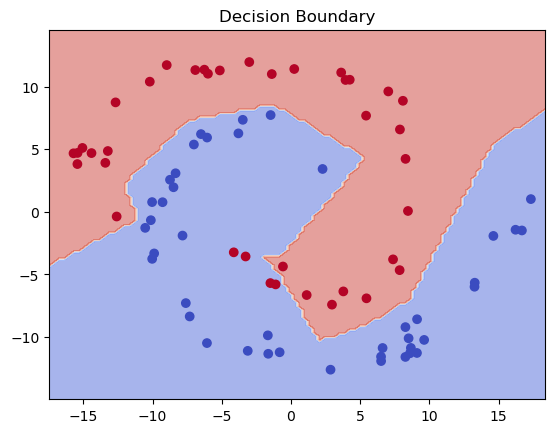

Time elapsed: 0.35 seconds
Fold 9/10
[[-10.2834   -1.55492]
 [ -8.71022  -4.9332 ]
 [  1.0699   13.33009]
 ...
 [ -4.40184  13.62807]
 [  8.48576  -1.65946]
 [ -2.30995  12.86967]]
[  0   1   2   3   5   6   7   8   9  10  11  12  13  15  16  17  18  19
  20  21  22  23  24  25  26  28  29  30  31  33  34  36  37  38  39  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  63  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  86  87  88  89  90  91  92  93  94  96  97  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 129 130 131 132 133 135 136 137 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 157 158 160 161
 162 163 164 165 166 167 168 169 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 188 189 190 191 192 193 194 195 196 197 198 199
 201 202 203 204 205 207 208 209 210 211 212 213 214 215 218 219 220 221
 222 223 224 225

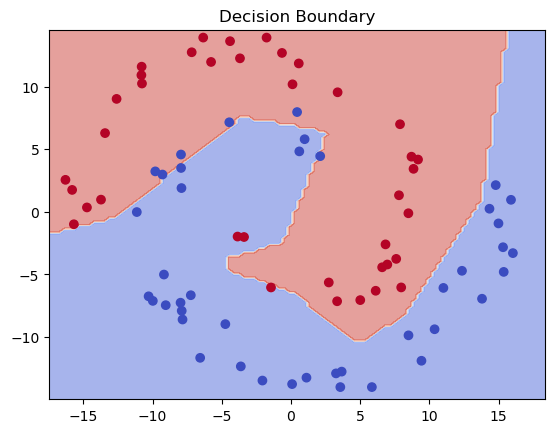

Time elapsed: 0.47 seconds
Fold 10/10
[[-10.2834   -1.55492]
 [ -8.71022  -4.9332 ]
 [  1.0699   13.33009]
 ...
 [ -4.40184  13.62807]
 [  8.48576  -1.65946]
 [ -2.30995  12.86967]]
[  0   2   3   4   5   6   7   8   9  10  11  12  14  15  16  17  18  19
  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  72  73  74  75  76  77  78
  79  81  82  83  84  85  86  88  89  90  92  93  94  95  96  97  98 100
 101 103 104 107 108 109 110 111 112 113 114 115 116 117 118 119 120 122
 123 124 125 126 127 128 129 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 162 163 164 165 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 190 192 193 194 195 196 197 198 199 200
 202 203 204 206 207 208 209 210 211 212 213 215 216 217 218 219 220 221
 222 223 224 22

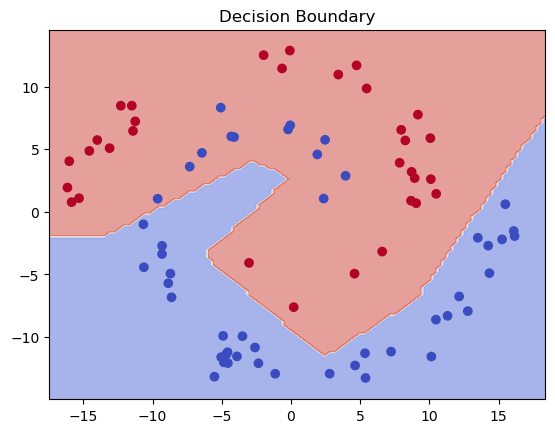

Time elapsed: 0.37 seconds
Average train loss: 3.0580, Average val loss: 1.9690
Fold 1, Training loss: 3.1502, Test loss: 2.0669
Fold 2, Training loss: 3.0640, Test loss: 1.9527
Fold 3, Training loss: 3.0296, Test loss: 1.9626
Fold 4, Training loss: 3.0283, Test loss: 1.9556
Fold 5, Training loss: 3.0212, Test loss: 1.9411
Fold 6, Training loss: 3.0606, Test loss: 1.9664
Fold 7, Training loss: 3.0432, Test loss: 1.9334
Fold 8, Training loss: 3.0416, Test loss: 1.9509
Fold 9, Training loss: 3.0601, Test loss: 1.9737
Fold 10, Training loss: 3.0817, Test loss: 1.9869

Average Training loss: 3.0580, Average Test loss: 1.9690



Training Results
Fold 1 Training Accuracy: 0.7652778029441833, Test Accuracy:0.800000011920929
Fold 2 Training Accuracy: 0.9319444298744202, Test Accuracy:0.9375
Fold 3 Training Accuracy: 0.9791666865348816, Test Accuracy:0.949999988079071
Fold 4 Training Accuracy: 0.9750000238418579, Test Accuracy:0.949999988079071
Fold 5 Training Accuracy: 0.9763888716697693, Test

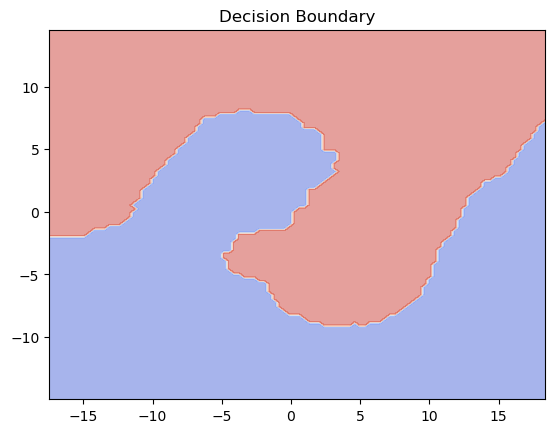

Average Fold Time: 0.41 Time elapsed: 4.27 seconds


In [16]:
##FFNN First Attempt
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.fc3 = nn.Linear(hidden_size, output_size, bias=True)
        #Define activation functions that can be used
        self.reluAct = nn.ReLU()
        self.tanAct = nn.Tanh()
        self.lReluAct = nn.LeakyReLU()
        self.sigmoidAct = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.reluAct(x)
        x = self.fc3(x)
        x = nn.Softmax(dim=0)(x)
        return x
    

# Changed these for initial 2 hidden layer FFNN the hyperparameters
input_size = 2
hidden_size = 6
output_size = 2
learning_rate = 0.04
num_epochs = 150
num_folds = 10

# Create the FFNN 
train_FFNN(X,y,num_folds,num_epochs,learning_rate,input_size,hidden_size,output_size)